Loaded T2_2000-03.nc
Loaded SNOWNC_2000-03.nc
Loaded RAINNC_2000-03.nc
Closest grid cell to Boise: i = 119, j = 129
Coordinates: lat = 43.616, lon = -116.191


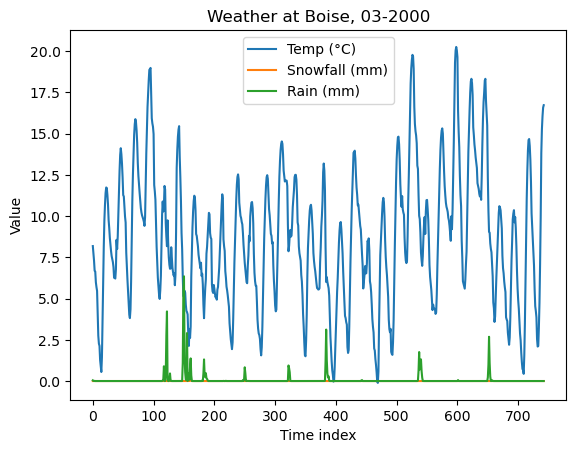

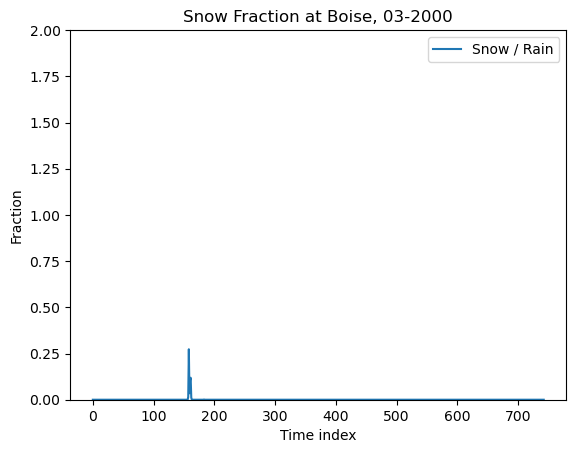

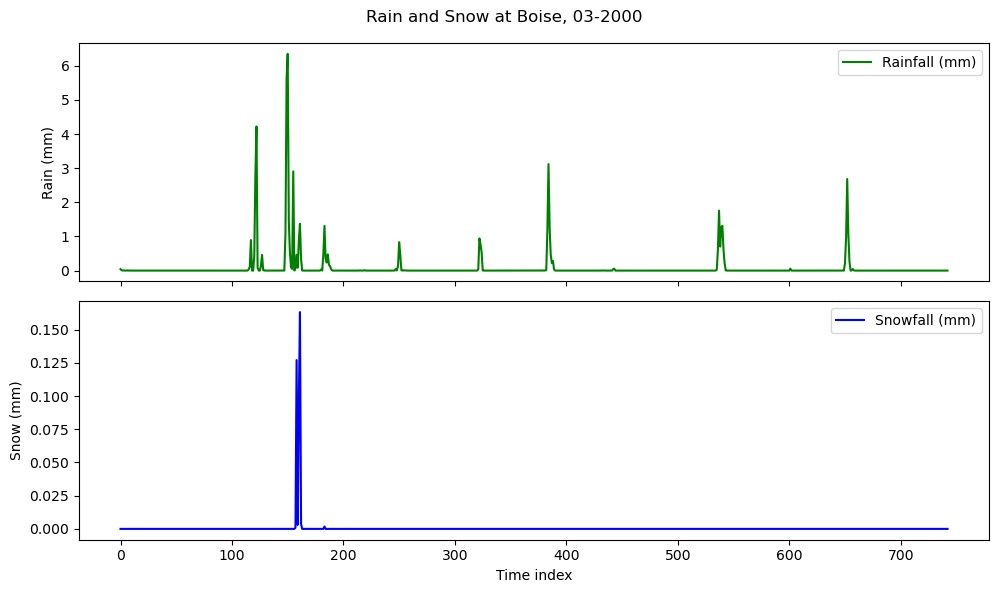

In [11]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt

# === CONFIGURATION ===
base_dir = "/bsushare/leaf-shared/subset-output-wrf/vol04/wrf_out/wy_2000/d01/"
month = "03"
year = "2000"
target_location = "Boise"
target_lat = 43.615
target_lon = -116.202
epsilon = 1e-6  # to prevent division by zero

# === FUNCTION TO LOAD A VARIABLE ===
def load_wrf_var(var_name, base_dir, year, month):
    filename = f"{var_name}_{year}-{month}.nc"
    path = os.path.join(base_dir, filename)
    try:
        ds = xr.open_dataset(path)
        print(f"Loaded {filename}")
        return ds
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return None

# === LOAD REQUIRED DATASETS ===
t2 = load_wrf_var("T2", base_dir, year, month)
snownc = load_wrf_var("SNOWNC", base_dir, year, month)
rainnc = load_wrf_var("RAINNC", base_dir, year, month)

# === FIND CLOSEST GRID CELL TO TARGET LOCATION ===
lats = t2['XLAT'][0, :, :].values
lons = t2['XLONG'][0, :, :].values
dist = np.sqrt((lats - target_lat)**2 + (lons - target_lon)**2)
i, j = np.unravel_index(np.argmin(dist), dist.shape)

print(f"Closest grid cell to {target_location}: i = {i}, j = {j}")
print(f"Coordinates: lat = {lats[i, j]:.3f}, lon = {lons[i, j]:.3f}")

# === EXTRACT TIME SERIES FOR TARGET LOCATION ===
temp_series = t2['T2'][:, i, j] - 273.15  # Convert from K to °C
snow_series = snownc['SNOWNC'][:, i, j]
rain_series = rainnc['RAINNC'][:, i, j]
time = t2['XTIME']

# === DIFFERENCING FUNCTION TO HANDLE ROLLOVER ===
def compute_hourly_precip(accum_series):
    diff = accum_series.diff(dim="Time", label="upper")
    prev = accum_series[:-1]
    corrected = xr.where(diff < 0, diff + prev, diff)
    return corrected.clip(min=0)

# === HOURLY PRECIP TIME SERIES ===
snow_hourly = compute_hourly_precip(snow_series)
rain_hourly = compute_hourly_precip(rain_series)

# === ALIGN TEMPERATURE TO MATCH HOURLY SERIES ===
temp_series_trimmed = temp_series.isel(Time=slice(1, None))

# === FRACTION CALCULATIONS ===
snow_frac = snow_hourly / (rain_hourly + epsilon)

# === COMBINE DATASET ===
combined = xr.Dataset({
    "temp_C": temp_series_trimmed,
    "snow_mm": snow_hourly,
    "rain_mm": rain_hourly,
    "snow_frac": snow_frac
})

# === PLOT TEMPERATURE + PRECIP ===
combined['temp_C'].plot(label="Temp (°C)")
combined['snow_mm'].plot(label="Snowfall (mm)")
combined['rain_mm'].plot(label="Rain (mm)")
plt.legend()
plt.title(f"Weather at {target_location}, {month}-{year}")
plt.xlabel("Time index")
plt.ylabel("Value")
plt.show()

# === PLOT FRACTIONS ===
combined['snow_frac'].plot(label="Snow / Rain")
plt.legend()
plt.title(f"Snow Fraction at {target_location}, {month}-{year}")
plt.xlabel("Time index")
plt.ylabel("Fraction")
plt.ylim(0, 2)
plt.show()

# === PLOT RAIN AND SNOW SIDE BY SIDE ===
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axs[0].plot(rain_hourly, label="Rainfall (mm)", color="green")
axs[0].set_ylabel("Rain (mm)")
axs[0].legend()

axs[1].plot(snow_hourly, label="Snowfall (mm)", color="blue")
axs[1].set_ylabel("Snow (mm)")
axs[1].legend()

plt.xlabel("Time index")
plt.suptitle(f"Rain and Snow at {target_location}, {month}-{year}")
plt.tight_layout()
plt.show()